# ImageNetAI
이미지 복원 기술은 손상되거나, 결손된 부분을 복구하고, 흑백 이미지에 자연스러운 색을 입히는 기술로, 역사적 사진 복원, 영상 편집, 의료 이미지 복구 등 다양한 분야에서 중요하게 활용되고 있음

### 주제
이미지의 색상화와 손실 부분을 복원하는 AI 알고리즘 개발

# 필요한 라이브러리 임포트

In [29]:
import random
import numpy as np
import pandas as pd
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import cv2
import zipfile
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 먼저, 데이터 전처리부터 진행
#### 데이터 구성:
- train_input(폴더): 흑백, 일부 손상된 PNG 학습 이미지 (input, 29603장)
- train_gt(폴더): 원본 PNG 이미지 (target, 29603장)
- train.csv (파일): PNG 파일의 경로 (메타 데이터 느낌)

- test_input(폴더): 흑백, 일부 손상된 PNG 평가 이미지 (input, 100장)
- test.csv (파일): PNG 파일의 경로 (메타 데이터 느낌)

#### 메타데이터인 train.csv 파일과 test.csv 파일 읽어서 칼럼 뽑기

In [30]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.columns)
print(test_df.columns)

Index(['input_image_path', 'gt_image_path'], dtype='object')
Index(['input_image_path'], dtype='object')


## 기본 전처리 정의 (단순 리사이즈 + 텐서 변환)

In [31]:
basic_transform_input = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
basic_transform_target = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 1. 입력과 타깃 이미지에 동일하게 랜덤 회전과 랜덤 크롭을 적용(JointAugmentation 클래스)

In [33]:
class JointAugmentation:
    def __init__(self, rotation_range=30, crop_size=(256, 256)):
        self.rotation_range = rotation_range
        self.crop_size = crop_size

    def __call__(self, input_img, target_img):
        # 랜덤 회전
        angle = random.uniform(-self.rotation_range, self.rotation_range)
        input_img = TF.rotate(input_img, angle)
        target_img = TF.rotate(target_img, angle)
        # 랜덤 크롭: 입력 이미지에서 crop 파라미터를 구한 후 동일하게 적용
        i, j, h, w = transforms.RandomCrop.get_params(input_img, output_size=self.crop_size)
        input_img = TF.crop(input_img, i, j, h, w)
        target_img = TF.crop(target_img, i, j, h, w)
        return input_img, target_img

# 2. 입력과 타깃 이미지에 랜덤 수평 및 (옵션) 수직 플립 적용 (RandomFlipAugmentation)

In [34]:
class RandomFlipAugmentation:
    def __init__(self, horizontal_prob=0.5, vertical_prob=0.0):
        self.horizontal_prob = horizontal_prob
        self.vertical_prob = vertical_prob
    
    def __call__(self, input_img, target_img):
        if random.random() < self.horizontal_prob:
            input_img = TF.hflip(input_img)
            target_img = TF.hflip(target_img)
        if random.random() < self.vertical_prob:
            input_img = TF.vflip(input_img)
            target_img = TF.vflip(target_img)
        return input_img, target_img

# 3. JointAugmentation과 RandomFlipAugmentation을 순차적으로 적용 (CombinedAugmentation)

In [35]:
class CombinedAugmentation:
    def __init__(self, joint_aug, flip_aug):
        self.joint_aug = joint_aug
        self.flip_aug = flip_aug
        
    def __call__(self, input_img, target_img):
        input_img, target_img = self.joint_aug(input_img, target_img)
        input_img, target_img = self.flip_aug(input_img, target_img)
        return input_img, target_img

# 4. CSV 파일에 기록된 이미지 경로 정보를 사용해 입력(흑백)과 타깃(컬러) 이미지를 로드 (RestorationDataset)

In [36]:
class RestorationDataset(Dataset):
    def __init__(self, csv_file, input_dir, target_dir=None, transform_input=None, transform_target=None, joint_transform=None):
        """
        csv_file: 이미지 경로 정보가 담긴 CSV 파일 경로
        input_dir: 입력 이미지가 저장된 디렉토리 (예: train_input)
        target_dir: 타깃 이미지가 저장된 디렉토리 (예: train_gt); test 데이터인 경우 None
        transform_input: 입력 이미지에 개별적으로 적용할 전처리 (ex. ToTensor 등)
        transform_target: 타깃 이미지에 개별적으로 적용할 전처리
        joint_transform: 입력과 타깃 이미지에 동시에 적용할 전처리 (ex. 랜덤 증강)
        """
        self.data = pd.read_csv(csv_file)
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform_input = transform_input
        self.transform_target = transform_target
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # CSV에 저장된 경로에서 파일명만 추출하여 사용 (중복 경로 방지)
        input_file = os.path.basename(self.data.iloc[idx]['input_image_path'])
        input_path = os.path.join(self.input_dir, input_file)
        input_img = Image.open(input_path).convert('L')  # 흑백 변환

        if self.target_dir is not None:
            target_file = os.path.basename(self.data.iloc[idx]['gt_image_path'])
            target_path = os.path.join(self.target_dir, target_file)
            target_img = Image.open(target_path).convert('RGB')  # 컬러 변환
        else:
            target_img = None

        # joint_transform 적용 (있다면)
        if self.joint_transform is not None and target_img is not None:
            input_img, target_img = self.joint_transform(input_img, target_img)
        
        # 개별 transform 적용 (ToTensor 등)
        if self.transform_input:
            input_img = self.transform_input(input_img)
        if self.transform_target and target_img is not None:
            target_img = self.transform_target(target_img)

        return input_img, target_img

# 5. --- 다양한 전처리 방식으로 데이터셋 생성 ---

In [37]:
# Basic Dataset: 단순 리사이즈 + ToTensor
basic_dataset = RestorationDataset(
    csv_file='train.csv',
    input_dir='train_input',
    target_dir='train_gt',
    transform_input=basic_transform_input,
    transform_target=basic_transform_target
)

# Joint Augmentation Dataset: 랜덤 회전 및 크롭 적용 후 ToTensor
joint_aug = JointAugmentation(rotation_range=30, crop_size=(256, 256))
joint_dataset = RestorationDataset(
    csv_file='train.csv',
    input_dir='train_input',
    target_dir='train_gt',
    joint_transform=joint_aug,
    transform_input=transforms.ToTensor(),
    transform_target=transforms.ToTensor()
)

# Random Flip Augmentation Dataset: 랜덤 플립 적용 후 ToTensor
flip_aug = RandomFlipAugmentation(horizontal_prob=0.7, vertical_prob=0.3)
flip_dataset = RestorationDataset(
    csv_file='train.csv',
    input_dir='train_input',
    target_dir='train_gt',
    joint_transform=flip_aug,
    transform_input=transforms.ToTensor(),
    transform_target=transforms.ToTensor()
)

# Combined Augmentation Dataset: Joint + Flip 적용 후 ToTensor
combined_aug = CombinedAugmentation(joint_aug, flip_aug)
combined_dataset = RestorationDataset(
    csv_file='train.csv',
    input_dir='train_input',
    target_dir='train_gt',
    joint_transform=combined_aug,
    transform_input=transforms.ToTensor(),
    transform_target=transforms.ToTensor()
)

# 6. 시각화

In [40]:
def visualize_samples(dataset, n_samples=10, title_prefix=""):
    """
    dataset: 시각화할 RestorationDataset 객체
    n_samples: 출력할 샘플 수
    title_prefix: 서브플롯 제목에 추가할 접두어 (예: "Basic", "Joint Augmentation" 등)
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(2 * n_samples, 4))
    fig.suptitle(f"{title_prefix} samples", fontsize=16)
    for i in range(n_samples):
        input_img, target_img = dataset[i]
        # 입력 이미지: 채널 수 1인 경우 2D로 변환하여 출력
        if input_img.shape[0] == 1:
            input_np = input_img.squeeze(0).numpy()
            axes[0, i].imshow(input_np, cmap='gray')
        else:
            input_np = input_img.numpy().transpose(1, 2, 0)
            axes[0, i].imshow(input_np)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")
        
        # 타깃 이미지: (3, H, W) 형태를 (H, W, 3)로 변환하여 출력
        target_np = target_img.numpy().transpose(1, 2, 0)
        axes[1, i].imshow(target_np)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")
    plt.tight_layout()
    plt.show()

# --- 각 전처리 방식별 샘플 시각화 ---

Visualizing Basic Dataset


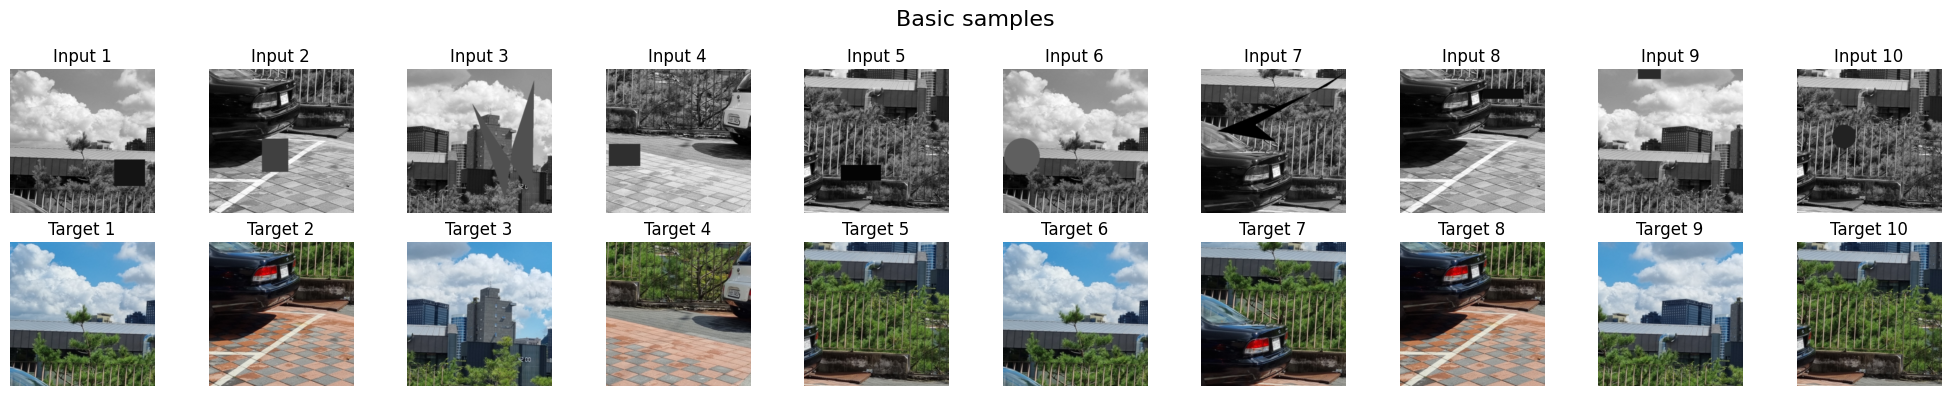

Visualizing Joint Augmentation Dataset


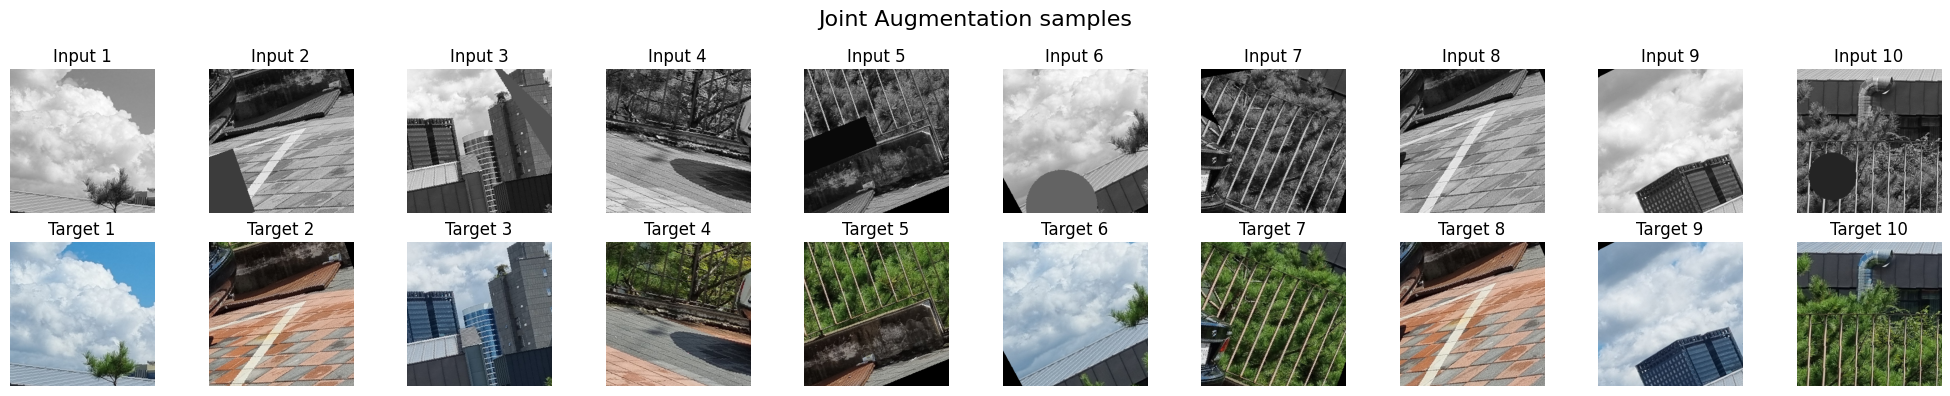

Visualizing Random Flip Augmentation Dataset


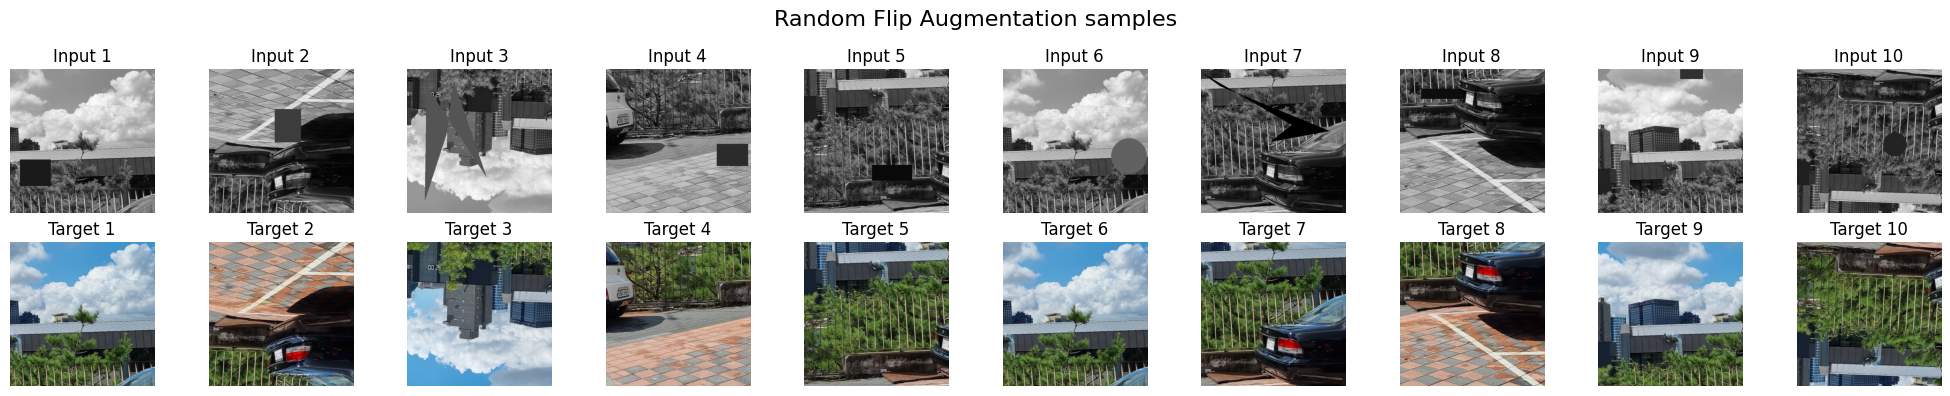

Visualizing Combined Augmentation Dataset


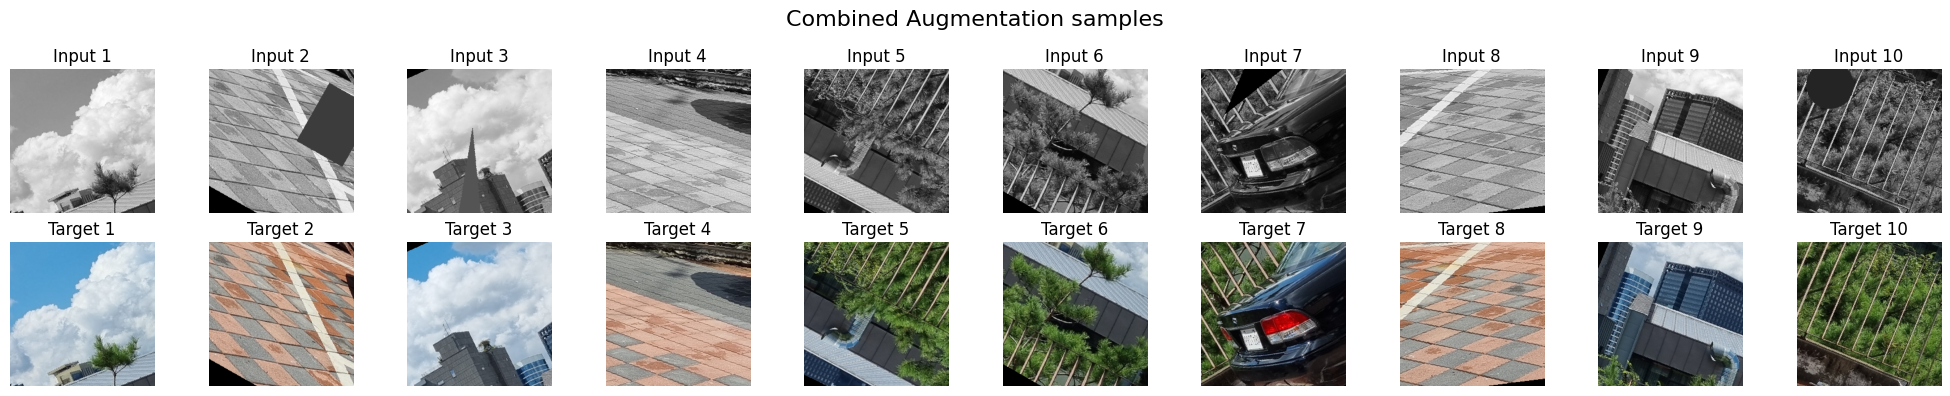

In [41]:
print("Visualizing Basic Dataset")
visualize_samples(basic_dataset, n_samples=10, title_prefix="Basic")

print("Visualizing Joint Augmentation Dataset")
visualize_samples(joint_dataset, n_samples=10, title_prefix="Joint Augmentation")

print("Visualizing Random Flip Augmentation Dataset")
visualize_samples(flip_dataset, n_samples=10, title_prefix="Random Flip Augmentation")

print("Visualizing Combined Augmentation Dataset")
visualize_samples(combined_dataset, n_samples=10, title_prefix="Combined Augmentation")